# The science of the soul: Doctrinal tendencies and clusters

This notebook contains the quantitative analyses of doctrinal tendencies and clusters on the possibility of having a science of the soul in the included commentaries. 


## Setup and utility functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as npJ
import matplotlib.pyplot as plt
from os import path

%matplotlib inline

sns.set_context("paper", font_scale=1.2)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Type hinting
from typing import Callable, Dict, List

In [ ]:
# Include some general utility functions
from utilities import run_query, save_table, print_figure_inclusion

## Analysis

We are ready to start the analysis proper.

The main objectives are:

1. Get some general information about the quantities, distribution and variety across the material.
2. Identify clusters of commentators based on how many doctrines they share among each other.

### Included authors
Load the authors that we want to analyze into a variable. We include everybody except Aristotle himself.

In [12]:
q = ("MATCH (n:Author) where not n.name = 'Aristotle' "
     "RETURN n.name ORDER BY n.name asc")
author_names = [t[0] for t in run_query(q).values()]

### General quantities

Let's look at some general quantities, both on all kinds of doctrines and within special types such as first level determination doctrines and *rationes principales*.

Note however that not all doctrines need be either a supporting or attacking doctrine of a specific other doctrine.
The obvious example is of course a root doctrine such as the basic positive idea that there can be a science about the soul, but some doctrines also describe a general tendency that can occur across a range of different discussions (e.g. the distinction between proper and improper science).

#### Doctrines in general numbers

In [131]:
# All doctrines on the question (5 levels deep, which is sufficient here)
q = ("MATCH (d:Doctrine)<-[:CONTAINS]-(:Question)-[:INSTANCE_OF]->(:QuestionType {name:'Science of the soul'})"
     "RETURN count(distinct d)")
run_query(q).single()[0]

53

In [132]:
# First level positive doctrines
q = ("MATCH (d:Doctrine)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
     "RETURN count(distinct d)")
run_query(q).single()[0]

11

In [133]:
# First level negative rationes
q = ("MATCH (d:Doctrine)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
     "RETURN count(distinct d)")
run_query(q).single()[0]

18

In [134]:
# Attacks on negative rationes (= refutation doctrines)
q = ("MATCH (d:Doctrine)-[:ATTACKS]->(:Doctrine)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
     "RETURN count(distinct d)")
run_query(q).single()[0]

19

#### How many doctrines per commentator?

In [204]:
def commentator_doctrines(name: str) -> List[int]:
    q_all = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
             "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
             "WHERE (q)-[:INSTANCE_OF]->(:QuestionType {name:'Science of the soul'})"
             "AND a.name = '%s'"
             "RETURN count(distinct d)" % name)
    q_pos = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
             "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
             "WHERE (d)-[:SUPPORTS]-(root)"
             "AND a.name = '%s'"
             "RETURN count(distinct d)" % name)
    q_att = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
             "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
             "WHERE (d)-[:ATTACKS]->(root)"
             "AND a.name = '%s'"
             "RETURN count(distinct d)" % name)
    q_ref = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
             "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
             "WHERE (d:Doctrine)-[:ATTACKS]->(:Doctrine)-[:ATTACKS]->(root)"
             "AND a.name = '%s'"
             "RETURN count(distinct d)" % name)
    q_free = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
              "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
              "WHERE (q)-[:INSTANCE_OF]->(:QuestionType {name:'Science of the soul'})"
              "AND NOT (d)--(:Doctrine)"
              "AND a.name = '%s'"
              "RETURN count(distinct d)" % name)
    res_all = run_query(q_all).single()[0]
    res_pos = run_query(q_pos).single()[0]
    res_att = run_query(q_att).single()[0]
    res_ref = run_query(q_ref).single()[0]
    res_free = run_query(q_free).single()[0]
    return [res_pos, res_free, res_att + res_ref, res_att, res_ref, res_all]
    
# Test with one of the guys.
commentator_doctrines('John of Jandun')

[2, 2, 12, 8, 4, 16]

In [205]:
# Build a matrix of all the commentators
count_all = {author: commentator_doctrines(author) for author in author_names}

In [206]:
# Put it in a dataframe and present the table
df_count_all = pd.DataFrame(count_all, index=['Positive', 'Free', 'Rationes', 'Attacking', 'Refuting', 'All'])
df_count_all = df_count_all.T # Transpose to have present rows rather than colums of observations
df_count_all.sort_values(by='All', ascending=False)

,Positive,Free,Rationes,Attacking,Refuting,All
Anonymus Mertoniensis 275,6,1,12,6,6,19
Henric de la Wyle,3,1,12,5,7,17
John of Jandun,2,2,12,8,4,16
Anonymus Oriel 33,3,1,11,5,6,14
Anonymus Bernardini,5,0,8,4,4,13
John Dinsdale,3,1,10,5,5,13
Simon of Faversham,3,2,8,4,4,13
Anonymus Vat. Lat. 2170 I,5,0,6,3,3,12
Radulphus Brito,3,2,7,4,3,12
Anonymus Vennebusch,3,1,4,2,2,8


In [207]:
# General summaries of the values
df_count_all.describe().round(2)

,Positive,Free,Rationes,Attacking,Refuting,All
count,14.00,14.00,14.00,14.00,14.00,14.00
mean,2.93,0.86,7.71,3.93,3.79,11.71
std,1.54,0.77,3.17,1.77,1.67,4.14
min,1.00,0.00,4.00,2.00,2.00,6.00
25%,2.00,0.00,5.00,2.25,2.25,7.25
50%,3.00,1.00,7.50,4.00,3.50,12.50
75%,3.00,1.00,10.75,5.00,4.75,13.75
max,6.00,2.00,12.00,8.00,7.00,19.00


#### Unique and shared determination points

In [216]:
def count_unique_determination_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT (:Question)--(d)--(q:Question)"
         "RETURN count(distinct d)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_determination_doctrines('John of Jandun')

0

In [217]:
def count_shared_determination_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s' and not(a.name = 'Aristotle')"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_determination_doctrines('John of Jandun')

2

Proportion unique of all doctrines

In [218]:
def unique_to_shared_proportion(unique, shared):
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion(
    count_unique_determination_doctrines('John of Jandun'),
    count_shared_determination_doctrines('John of Jandun')
)

0.0

Now let's get the values of these for all the commentators and put them into a matrix.

In [220]:
def unique_shared_determinations_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_determination_doctrines(a)
        shared = count_shared_determination_doctrines(a)
        prop = unique_to_shared_proportion(unique, shared)
        
        d[a] = [unique, shared, unique + shared, prop]
    return d

# Example
m = unique_shared_determinations_all(author_names)

Put this in a DataFrame and sort according to highest proportion of unique.

In [221]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].astype(int)
df.round(1).sort_values(by='Proportion', ascending=False)

,Unique,Shared,Sum,Proportion
Anonymus Steenberghen,1,1,2,0.5
Henric de la Wyle,1,2,3,0.3
Anonymus Bernardini,1,4,5,0.2
Anonymus Vat. Lat. 2170 I,1,4,5,0.2
Anonymus Bazan I,0,1,1,0.0
Anonymus Giele,0,1,1,0.0
Anonymus Mertoniensis 275,0,6,6,0.0
Anonymus Oriel 33,0,3,3,0.0
Anonymus Vat. Lat. 2170 II,0,1,1,0.0
Anonymus Vennebusch,0,3,3,0.0


In [223]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     4
Shared    37
Sum       41
dtype: int64

In [224]:
# Proportion in percent?
round((df['Unique'].sum() / df['Sum'].sum()) * 100, 1)

9.8

#### Unique and shared attacks and refutations

##### Attacks

In [225]:
def count_unique_negative_doctrines(name):
    q = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE (d)-[:ATTACKS]-(root)"
         "AND NOT (:Question)--(d)--(q:Question)"
         "AND a.name = '%s'"
         "RETURN count(distinct d)" % name)
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_negative_doctrines('John of Jandun')

2

In [226]:
def count_shared_negative_doctrines(name):
    q = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE (d)-[:ATTACKS]->(root)"
         "AND a.name = '%s'"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_negative_doctrines('John of Jandun')

6

Proportion unique of all doctrines

In [228]:
def unique_to_shared_proportion(unique, shared):
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion(
    count_unique_negative_doctrines('John of Jandun'),
    count_shared_negative_doctrines('John of Jandun')
)

0.25

Now let's get the values of these for all the commentators and put them into a matrix.

In [231]:
def unique_shared_determinations_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_negative_doctrines(a)
        shared = count_shared_negative_doctrines(a)
        prop = unique_to_shared_proportion(unique, shared)
        
        d[a] = [unique, shared, unique + shared, prop]
    return d

# Example
m = unique_shared_determinations_all(author_names)

Put this in a DataFrame and sort according to highest proportion of unique.

In [254]:
df_attacks = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df_attacks.T
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].astype(int)
df.round(1).sort_values(by='Proportion', ascending=False)

,Unique,Shared,Sum,Proportion
Anonymus Bazan I,1,1,2,0.5
Anonymus Steenberghen,1,1,2,0.5
Henric de la Wyle,3,4,7,0.4
Anonymus Mertoniensis 275,2,4,6,0.3
Anonymus Bernardini,1,3,4,0.2
John of Jandun,1,3,4,0.2
Anonymus Giele,0,3,3,0.0
Anonymus Oriel 33,0,6,6,0.0
Anonymus Vat. Lat. 2170 I,0,3,3,0.0
Anonymus Vat. Lat. 2170 II,0,2,2,0.0


In [234]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     8
Shared    47
Sum       55
dtype: int64

In [239]:
# Proportion in percent?
round((df['Unique'].sum() / df['Sum'].sum()) * 100, 1)

14.5

##### Refutations

In [241]:
def count_unique_refutation_doctrines(name):
    q = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE (d)-[:ATTACKS]->(:Doctrine)-[:ATTACKS]->(root)"
         "AND NOT (:Question)--(d)--(q:Question)"
         "AND a.name = '%s'"
         "RETURN count(distinct d)" % name)
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_refutation_doctrines('John of Jandun')

1

In [248]:
def count_shared_refutation_doctrines(name):
    q = ("MATCH (root:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE (d)-[:ATTACKS]->(:Doctrine)-[:ATTACKS]->(root)"
         "AND a.name = '%s'"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_refutation_doctrines('John of Jandun')

3

Proportion unique of all doctrines

In [249]:
def unique_to_shared_proportion(unique, shared):
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion(
    count_unique_refutation_doctrines('John of Jandun'),
    count_shared_refutation_doctrines('John of Jandun')
)

0.25

Now let's get the values of these for all the commentators and put them into a matrix.

In [250]:
def unique_shared_refutations_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_refutation_doctrines(a)
        shared = count_shared_refutation_doctrines(a)
        prop = unique_to_shared_proportion(unique, shared)
        
        d[a] = [unique, shared, unique + shared, prop]
    return d

# Example
m = unique_shared_refutations_all(author_names)

Put this in a DataFrame and sort according to highest proportion of unique.

In [255]:
df_refutations = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df_refutations.T
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].astype(int)
df.round(1).sort_values(by='Proportion', ascending=False)

,Unique,Shared,Sum,Proportion
Anonymus Bazan I,1,1,2,0.5
Anonymus Steenberghen,1,1,2,0.5
Henric de la Wyle,3,4,7,0.4
Anonymus Mertoniensis 275,2,4,6,0.3
Anonymus Bernardini,1,3,4,0.2
John of Jandun,1,3,4,0.2
Anonymus Giele,0,3,3,0.0
Anonymus Oriel 33,0,6,6,0.0
Anonymus Vat. Lat. 2170 I,0,3,3,0.0
Anonymus Vat. Lat. 2170 II,0,2,2,0.0


In [256]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     9
Shared    44
Sum       53
dtype: int64

In [257]:
# Proportion in percent?
round((df['Unique'].sum() / df['Sum'].sum()) * 100, 1)

17.0

##### Both

In [2]:
df_rationes = df_attacks[0:3] + df_refutations[0:3]
df_rationes = df_rationes.T.astype(int)
df_rationes['Proportion'] = df_rationes['Unique'] / df_rationes['Sum']
df_rationes.round(2)

NameError: name 'df_attacks' is not defined

## Relative proportions: The  proportional distribution matrix

To get a better idea of the relation of one commentator to any other, we calculate how many of their total doctrines they share.

In [24]:
def number_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q:Question)--(d)--(:Question)--(:Text)--(a2:Author)"
                         "WHERE a.name = {name}"
                         "RETURN a2.name, count(distinct d)", name=name)
            return {r[0]: r[1] for r in res}

number_shared_determination_doctrines('Anonymus Giele')

{'Anonymus Bernardini': 1,
 'Anonymus Mertoniensis 275': 1,
 'Anonymus Oriel 33': 1,
 'Anonymus Vat. Lat. 2170 I': 1,
 'Anonymus Vennebusch': 1,
 'John Dinsdale': 1,
 'John of Jandun': 1,
 'Radulphus Brito': 1,
 'Simon of Faversham': 1}

In [25]:
def proportion_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q1:Question)--(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (q1:Question)--(d1:Doctrine) WHERE (d1)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "MATCH (q2:Question)--(d2:Doctrine) WHERE (d2)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Bernardini': 0.26666666666666666,
 'Anonymus Giele': 0.3333333333333333,
 'Anonymus Mertoniensis 275': 0.5,
 'Anonymus Oriel 33': 1.0,
 'Anonymus Vat. Lat. 2170 I': 0.26666666666666666,
 'Anonymus Vat. Lat. 2170 II': 0.3333333333333333,
 'Anonymus Vennebusch': 0.4444444444444444,
 'Henric de la Wyle': 0.4444444444444444,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.6666666666666666,
 'Radulphus Brito': 0.4444444444444444,
 'Simon of Faversham': 0.4444444444444444}

In [26]:
author_names

['Anonymus Bazan I',
 'Anonymus Bernardini',
 'Anonymus Giele',
 'Anonymus Mertoniensis 275',
 'Anonymus Oriel 33',
 'Anonymus Steenberghen',
 'Anonymus Vat. Lat. 2170 I',
 'Anonymus Vat. Lat. 2170 II',
 'Anonymus Vennebusch',
 'Henric de la Wyle',
 'John Dinsdale',
 'John of Jandun',
 'Radulphus Brito',
 'Simon of Faversham']

In [27]:

def build_matrix(authors, docfunc=proportion_shared_determination_doctrines):
    matrix = {}
    for author in authors:
        matrix[author] = []
        values = docfunc(author)
        for name in authors:
            if name in values:
                matrix[author].append(values[name])
            else:
                matrix[author].append(0)
    return matrix

d = build_matrix(author_names)
            

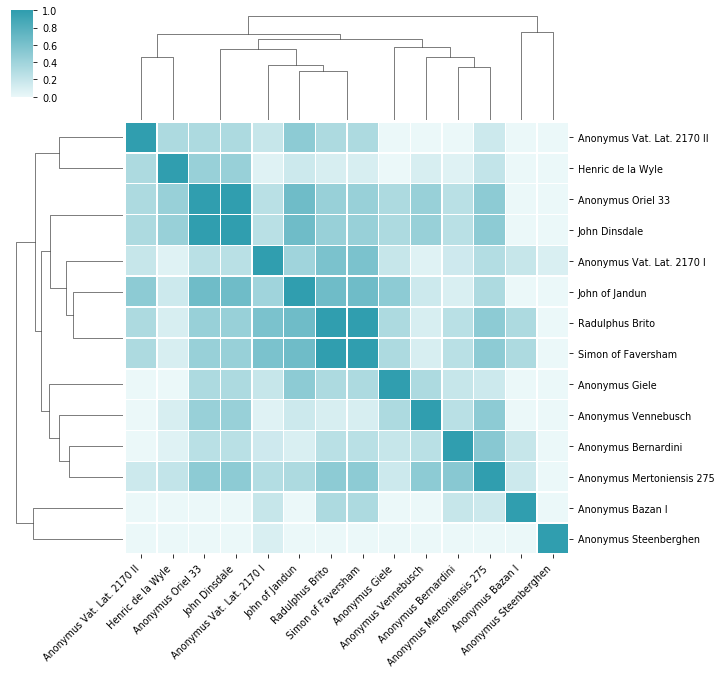

In [28]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [241]:
plot.savefig('../thesis/data/figures/science-determ-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-determ-proportional-clustermap', plot,
    caption='Proportional clustermap of determination doctrines.',
    label='fig:sci:determ:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-determ-proportional-clustermap.pdf}
\caption{Proportional clustermap of determination doctrines.}
\label{fig:sci:determ:prop-clustermap}
\end{figure}


In [242]:
# Mean commonality values 
df.mean().sort_values(ascending=False).round(1)

John Dinsdale                 0.4
Anonymus Oriel 33             0.4
Simon of Faversham            0.4
Radulphus Brito               0.4
John of Jandun                0.4
Anonymus Mertoniensis 275     0.4
Anonymus Vat. Lat. 2170 I     0.3
Anonymus Giele                0.3
Anonymus Bernardini           0.3
Anonymus Vennebusch           0.3
Anonymus Vat. Lat. 2170 II    0.3
Henric de la Wyle             0.2
Anonymus Bazan I              0.2
Anonymus Steenberghen         0.1
dtype: float64

In [243]:
# Dinsdale example
dins = df['John Dinsdale'].round(decimals=2)
save_table('../thesis/data/tables/dinsdale-fingerprint.tex', dins.to_latex(), 
           caption='Example of proportional shared profile for determination doctrines of John Dinsdale.',
           label='tab:sci:determ:profile-dinsdale')
dins

Anonymus Bazan I              0.00
Anonymus Bernardini           0.27
Anonymus Giele                0.33
Anonymus Mertoniensis 275     0.50
Anonymus Oriel 33             1.00
Anonymus Steenberghen         0.00
Anonymus Vat. Lat. 2170 I     0.27
Anonymus Vat. Lat. 2170 II    0.33
Anonymus Vennebusch           0.44
Henric de la Wyle             0.44
John Dinsdale                 1.00
John of Jandun                0.67
Radulphus Brito               0.44
Simon of Faversham            0.44
Name: John Dinsdale, dtype: float64

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

In [244]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author)--(t:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "RETURN d.name" % name )
    return [t[0] for t in run_query(q).values()]

# Example test
determination_doctrines_of("Anonymus Giele")

['Substantial knowledge from accidents']

Then we create a full list of all the doctrines in determinations.

In [245]:
def all_determination_doctrines():
    q = ("MATCH (d:Doctrine)--(:Question)"
         "WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT d.name = 'There can be a science of the soul'"
         "RETURN distinct d.name ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_determination_doctrines()

# Test output
all_docs

['Certain science about simple subject',
 'Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)',
 'Identity of knower and known',
 'Propter quod unumquodque tale et illud magis',
 'Science about a substance which contains parts and properties',
 'Science of form and perfection',
 'Science through self-reflection',
 'Science through subject, properties, principles',
 'Soul indirectly available to sense perception',
 'Substantial knowledge from accidents',
 'There can be science about everything with intelligible essence or definition']

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [246]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


df = pd.DataFrame(matrix, index=all_docs)

Okay, I want to sort the matrix by how many doctrines the texts contain. This means that we sort the columns based on the sum of the values. Oddly enough I can't figure out how to do that within the `DataFrame`, so instead I create a dict, from that a list of the authors sorted by their sum doctrines. That list is used for keys in building a new matrix with the desired order. But then the rows and columns are switched, so I need to transmute those with the `zip` function. *This just doesn't feel right*.

In [247]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = determination_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

,Anonymus Bernardini,Anonymus Steenberghen,Anonymus Mertoniensis 275,Anonymus Vennebusch,Anonymus Vat. Lat. 2170 I,Henric de la Wyle,Radulphus Brito,Simon of Faversham,Anonymus Bazan I,Anonymus Oriel 33,John Dinsdale,John of Jandun,Anonymus Vat. Lat. 2170 II,Anonymus Giele
Certain science about simple subject,x,,,,,,,,,,,,,
"Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)",,x,,,,,,,,,,,,
Identity of knower and known,x,,x,,,,,,,,,,,
Propter quod unumquodque tale et illud magis,,,x,x,,,,,,,,,,
Science about a substance which contains parts and properties,,x,,,x,,,,,,,,,
Science of form and perfection,,,,,,x,,,,,,,,
Science through self-reflection,x,,x,,x,,x,x,x,,,,,
"Science through subject, properties, principles",,,x,,x,x,x,x,,x,x,x,x,
Soul indirectly available to sense perception,x,,x,x,,x,,,,x,x,,,
Substantial knowledge from accidents,x,,x,x,x,,x,x,,x,x,x,,x


I can sort the sum of the DataFrame like this, but I can't figure out how to sort the columns by that.

In [248]:

df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums

Anonymus Mertoniensis 275     6
Anonymus Vat. Lat. 2170 I     5
Anonymus Bernardini           5
John Dinsdale                 3
Anonymus Oriel 33             3
Simon of Faversham            3
Radulphus Brito               3
Henric de la Wyle             3
Anonymus Vennebusch           3
John of Jandun                2
Anonymus Steenberghen         2
Anonymus Giele                1
Anonymus Vat. Lat. 2170 II    1
Anonymus Bazan I              1
dtype: int64

In [249]:
#print(sums.to_latex())

What is the mean amount of doctrines?

In [250]:
df.sum().mean()

2.9285714285714284

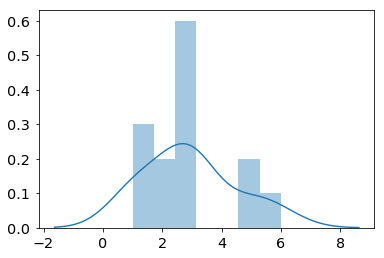

In [251]:
sns.distplot(df.sum())

### Popularity of arguments

In [252]:
df.sum(axis=1).sort_values(ascending=False)

Substantial knowledge from accidents                                                                       10
Science through subject, properties, principles                                                             9
Soul indirectly available to sense perception                                                               6
Science through self-reflection                                                                             6
Science about a substance which contains parts and properties                                               2
Propter quod unumquodque tale et illud magis                                                                2
Identity of knower and known                                                                                2
There can be science about everything with intelligible essence or definition                               1
Science of form and perfection                                                                              1
Four requi

# Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

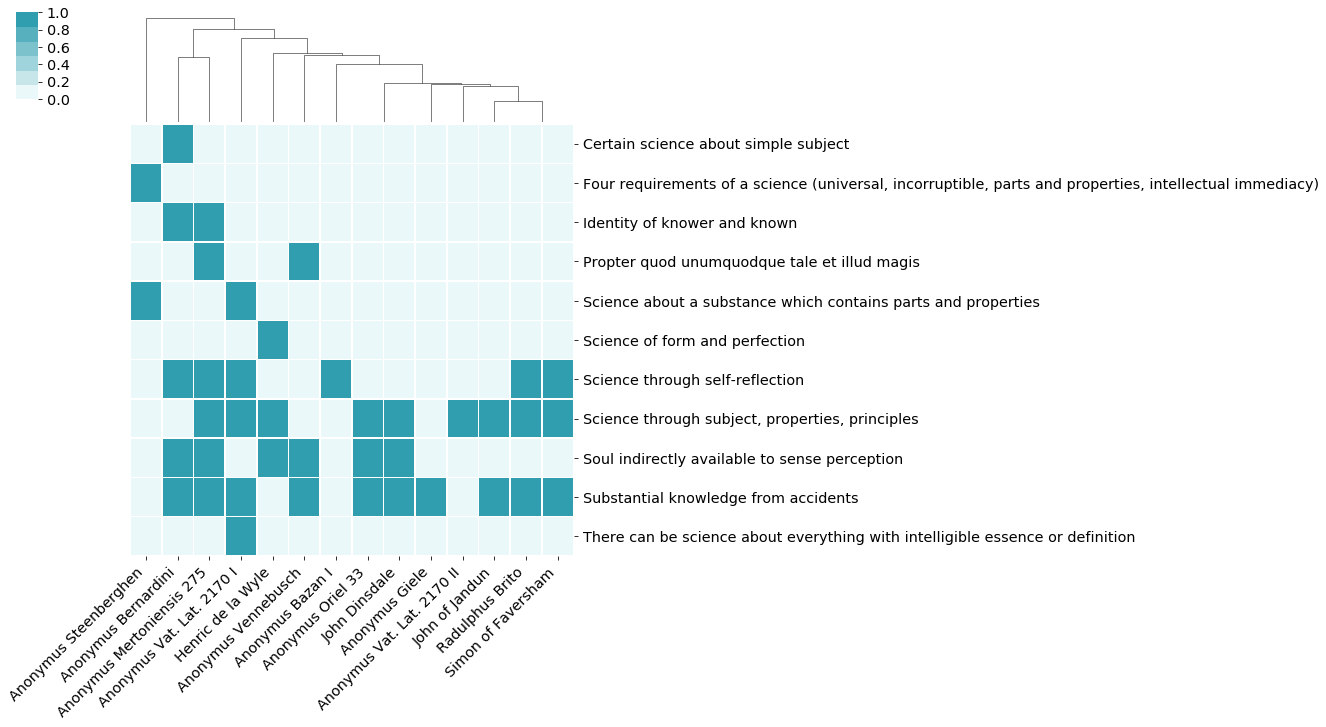

In [253]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=False, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

# Positive doctrines (determinations and rationes)

In [254]:
def count_unique_positive_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT (:Question)--(d)--(q:Question)"
         "RETURN count(distinct d)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_positive_doctrines('John of Jandun')

2

In [255]:
def count_shared_positive_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s' and not(a.name = 'Aristotle')"
         "AND NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_positive_doctrines('John of Jandun')

6

Proportion unique of all doctrines

In [256]:
def unique_to_shared_proportion(name):
    unique = count_unique_positive_doctrines(name)
    shared = count_shared_positive_doctrines(name)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun')

0.25

Now let's get the values of these for all the commentators and put them into a matrix.

In [258]:
def unique_shared_positive_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_positive_doctrines(a)
        shared = count_shared_positive_doctrines(a)
        prop = unique_to_shared_proportion(a)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_positive_all(author_names)

Put this in a DataFrame and sort according to most unique.

In [259]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Sum', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].apply(np.int64)
df

,Unique,Shared,Sum,Proportion
Anonymus Mertoniensis 275,2,11,13,0.15
Anonymus Oriel 33,0,9,9,0.00
Henric de la Wyle,1,8,9,0.11
Radulphus Brito,1,8,9,0.11
Simon of Faversham,1,8,9,0.11
Anonymus Vat. Lat. 2170 I,0,8,8,0.00
John Dinsdale,0,8,8,0.00
John of Jandun,2,6,8,0.25
Anonymus Bernardini,0,7,7,0.00
Anonymus Vennebusch,1,6,7,0.14


In [260]:
# Some saving could be set up here...
save_table('../thesis/data/tables/sci-determinations-quantities.tex', df.to_latex(), 
           caption='Unique, shared, total, and proportion of unique to shared doctrines in determinations.',
           label='tab:sci:determ:quantities')

In [261]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique      8
Shared     93
Sum       101
dtype: int64

In [264]:
# Number of distinct rationes
doctrine_count = run_query('MATCH (d:Doctrine)'
                           'WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:"There can be a science of the soul"})'
                           'AND NOT d.name="There can be a science of the soul"'
                           'RETURN count(DISTINCT d)').single()[0]
doctrine_count

35

In [265]:
# Proportion of unique
df['Unique'].sum() / doctrine_count

0.22857142857142856

In [266]:
# Proportion of unique instances
df['Unique'].sum() / df['Sum'].sum()

0.07920792079207921

In [267]:
# Average use number of non-uniques
round(df['Sum'].sum() / (doctrine_count - df['Unique'].sum()), 1)

3.7

## Proportional distribution matrix

In [268]:
def number_shared_positive_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q:Question)--(d)--(:Question)--(:Text)--(a2:Author)"
                         "WHERE a.name = {name}"
                         "RETURN a2.name, count(distinct d)", name=name)
            return {r[0]: r[1] for r in res}

number_shared_positive_doctrines('Anonymus Giele')

{'Anonymus Bazan I': 2,
 'Anonymus Bernardini': 2,
 'Anonymus Mertoniensis 275': 2,
 'Anonymus Oriel 33': 2,
 'Anonymus Steenberghen': 1,
 'Anonymus Vat. Lat. 2170 I': 4,
 'Anonymus Vat. Lat. 2170 II': 2,
 'Anonymus Vennebusch': 2,
 'Henric de la Wyle': 2,
 'John Dinsdale': 2,
 'John of Jandun': 4,
 'Radulphus Brito': 3,
 'Simon of Faversham': 4}

In [269]:
def proportion_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q1:Question)--(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (q1:Question)--(d1:Doctrine) WHERE NOT (d1)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "MATCH (q2:Question)--(d2:Doctrine) WHERE NOT (d2)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Bazan I': 0.03125,
 'Anonymus Bernardini': 0.2222222222222222,
 'Anonymus Giele': 0.125,
 'Anonymus Mertoniensis 275': 0.34615384615384615,
 'Anonymus Oriel 33': 0.8888888888888888,
 'Anonymus Steenberghen': 0.025,
 'Anonymus Vat. Lat. 2170 I': 0.125,
 'Anonymus Vat. Lat. 2170 II': 0.125,
 'Anonymus Vennebusch': 0.1875,
 'Henric de la Wyle': 0.375,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.125,
 'Radulphus Brito': 0.140625,
 'Simon of Faversham': 0.25}

In [270]:
author_names

['Anonymus Bazan I',
 'Anonymus Bernardini',
 'Anonymus Giele',
 'Anonymus Mertoniensis 275',
 'Anonymus Oriel 33',
 'Anonymus Steenberghen',
 'Anonymus Vat. Lat. 2170 I',
 'Anonymus Vat. Lat. 2170 II',
 'Anonymus Vennebusch',
 'Henric de la Wyle',
 'John Dinsdale',
 'John of Jandun',
 'Radulphus Brito',
 'Simon of Faversham']

In [271]:

def build_matrix(authors, docfunc=proportion_shared_determination_doctrines):
    matrix = {}
    for author in authors:
        matrix[author] = []
        values = docfunc(author)
        for name in authors:
            if name in values:
                matrix[author].append(values[name])
            else:
                matrix[author].append(0)
    return matrix

d = build_matrix(author_names)
            

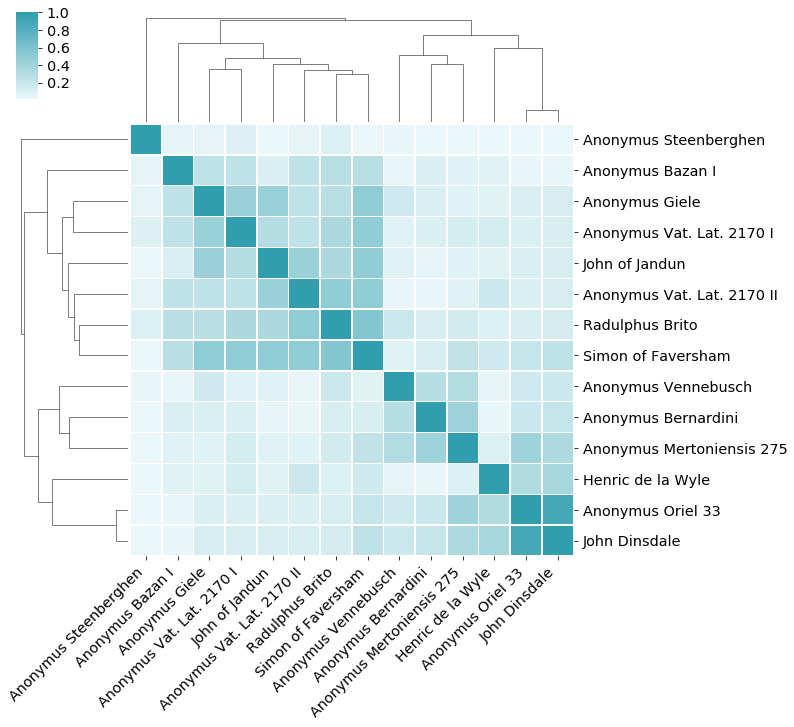

In [272]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [274]:
plot.savefig('../thesis/data/figures/science-positive-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-positive-proportional-clustermap', plot,
    caption='Proportional clustermap of positive doctrines.',
    label='fig:sci:positive:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-positive-proportional-clustermap.pdf}
\caption{Proportional clustermap of positive doctrines.}
\label{fig:sci:positive:prop-clustermap}
\end{figure}


In [275]:
# Mean commonality values 
df.mean().sort_values(ascending=False).round(1)

Simon of Faversham            0.4
Radulphus Brito               0.3
John Dinsdale                 0.3
Anonymus Vat. Lat. 2170 I     0.3
Anonymus Giele                0.3
Anonymus Oriel 33             0.3
Anonymus Vat. Lat. 2170 II    0.3
John of Jandun                0.3
Anonymus Mertoniensis 275     0.2
Anonymus Bernardini           0.2
Anonymus Bazan I              0.2
Henric de la Wyle             0.2
Anonymus Vennebusch           0.2
Anonymus Steenberghen         0.1
dtype: float64

In [276]:
# Dinsdale example
dins = df['John Dinsdale'].round(decimals=2)
save_table('../thesis/data/tables/dinsdale-fingerprint-positive.tex', dins.to_latex(), 
           caption='Example of proportional shared profile for positive doctrines of John Dinsdale.',
           label='tab:sci:determ:profile-dinsdale')
dins

Anonymus Bazan I              0.03
Anonymus Bernardini           0.22
Anonymus Giele                0.12
Anonymus Mertoniensis 275     0.35
Anonymus Oriel 33             0.89
Anonymus Steenberghen         0.02
Anonymus Vat. Lat. 2170 I     0.12
Anonymus Vat. Lat. 2170 II    0.12
Anonymus Vennebusch           0.19
Henric de la Wyle             0.38
John Dinsdale                 1.00
John of Jandun                0.12
Radulphus Brito               0.14
Simon of Faversham            0.25
Name: John Dinsdale, dtype: float64

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

In [277]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author)--(t:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND (d)-[:SUPPORTS|:USES]-()"
         "RETURN d.name" % name )
    return [t[0] for t in run_query(q).values()]

# Example test
determination_doctrines_of("Anonymus Giele")

['There can be a science of the soul', 'Substantial knowledge from accidents']

Then we create a full list of all the doctrines in determinations.

In [278]:
def all_determination_doctrines():
    q = ("MATCH (d:Doctrine)--(:Question)"
         "WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND (d)-[:SUPPORTS|:USES]-()"
         "AND NOT d.name = 'There can be a science of the soul'"
         "RETURN distinct d.name ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_determination_doctrines()

# Test output
all_docs

['Certain science about simple subject',
 'Different types of intelligibility',
 'Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)',
 'Identity of knower and known',
 'Intellect is not like senses but has reflexivity',
 'Propter quod unumquodque tale et illud magis',
 'Science about a substance which contains parts and properties',
 'Science from observations of accidents is also science',
 'Science of form and perfection',
 'Science through self-reflection',
 'Science through subject, properties, principles',
 'Soul has parts and properties in virtue of its embodied activities',
 'Soul indirectly available to sense perception',
 'Substantial knowledge from accidents',
 'There can be science about everything with intelligible essence or definition',
 'Three meanings of science']

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [279]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


df = pd.DataFrame(matrix, index=all_docs)

Okay, I want to sort the matrix by how many doctrines the texts contain. This means that we sort the columns based on the sum of the values. Oddly enough I can't figure out how to do that within the `DataFrame`, so instead I create a dict, from that a list of the authors sorted by their sum doctrines. That list is used for keys in building a new matrix with the desired order. But then the rows and columns are switched, so I need to transmute those with the `zip` function. *This just doesn't feel right*.

In [280]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = determination_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

,Anonymus Bernardini,Anonymus Mertoniensis 275,Anonymus Vennebusch,Anonymus Steenberghen,Anonymus Vat. Lat. 2170 I,Henric de la Wyle,Radulphus Brito,Simon of Faversham,Anonymus Bazan I,Anonymus Oriel 33,John Dinsdale,John of Jandun,Anonymus Vat. Lat. 2170 II,Anonymus Giele
Certain science about simple subject,x,,,,,,,,,,,,,
Different types of intelligibility,x,x,x,,,,,,,,,,,
"Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)",,,,x,,,,,,,,,,
Identity of knower and known,x,x,,,,,,,,,,,,
Intellect is not like senses but has reflexivity,,x,,,,,,,,,,,,
Propter quod unumquodque tale et illud magis,,x,x,,,,,,,,,,,
Science about a substance which contains parts and properties,,,,x,x,,,,,,,,,
Science from observations of accidents is also science,,x,,,,,,,,,,,,
Science of form and perfection,,,,,,x,,,,,,,,
Science through self-reflection,x,x,,,x,,x,x,x,,,,,


I can sort the sum of the DataFrame like this, but I can't figure out how to sort the columns by that.

In [281]:

df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums

Anonymus Mertoniensis 275     9
Anonymus Vat. Lat. 2170 I     6
Anonymus Bernardini           6
Radulphus Brito               4
Henric de la Wyle             4
Anonymus Vennebusch           4
John Dinsdale                 3
Anonymus Oriel 33             3
Simon of Faversham            3
Anonymus Steenberghen         3
John of Jandun                2
Anonymus Giele                1
Anonymus Vat. Lat. 2170 II    1
Anonymus Bazan I              1
dtype: int64

In [282]:
#print(sums.to_latex())

What is the mean amount of doctrines?

In [283]:
df.sum().mean()

3.5714285714285716

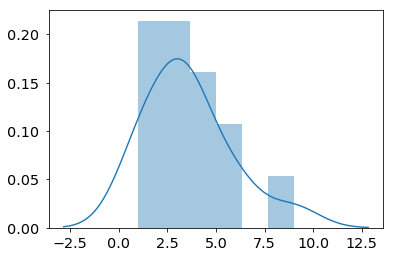

In [284]:
sns.distplot(df.sum())

### Popularity of arguments

In [285]:
df.sum(axis=1).sort_values(ascending=False)

Substantial knowledge from accidents                                                                       10
Science through subject, properties, principles                                                             9
Soul indirectly available to sense perception                                                               6
Science through self-reflection                                                                             6
Different types of intelligibility                                                                          3
Three meanings of science                                                                                   2
Soul has parts and properties in virtue of its embodied activities                                          2
Science about a substance which contains parts and properties                                               2
Propter quod unumquodque tale et illud magis                                                                2
Identity o

# Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

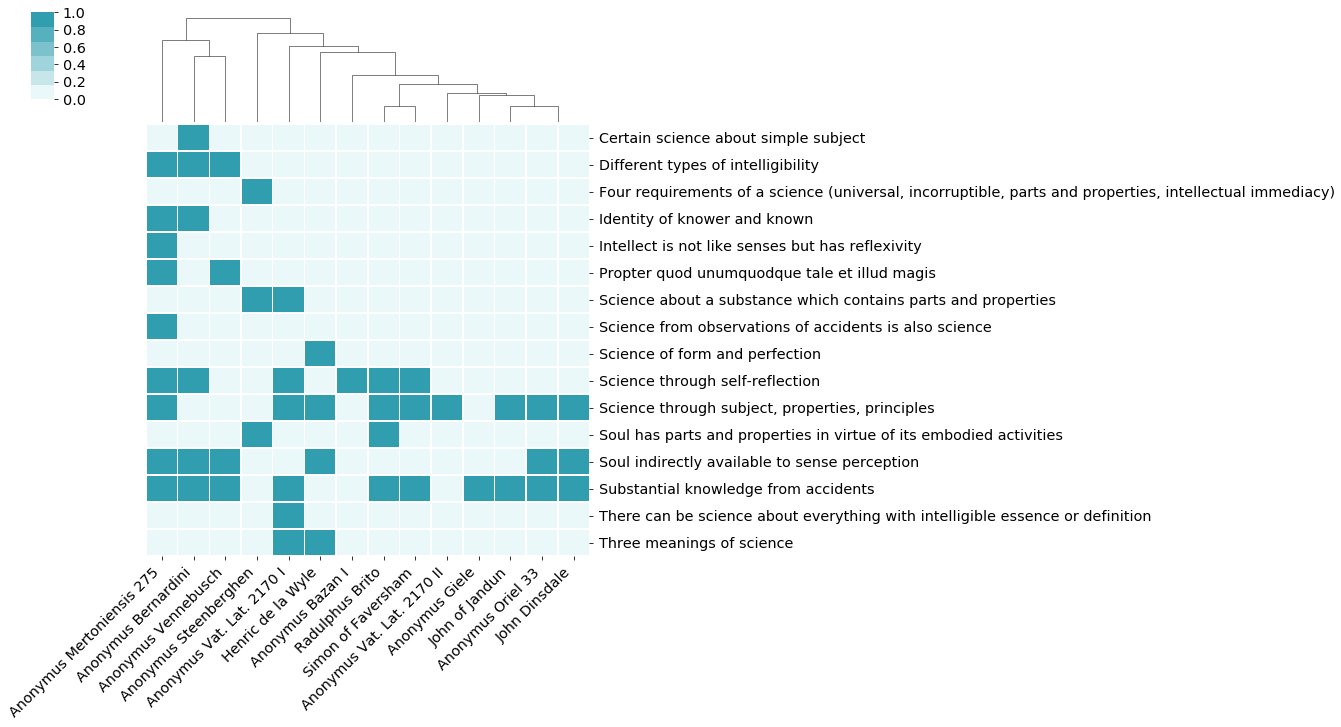

In [286]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=False, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [288]:
plot.savefig('../thesis/data/figures/science-positive-binary-clustermap.pdf')
print_figure_inclusion(
    'science-determinations-binary-clustermap', plot,
    caption='Binary clustermap of positive doctrines.',
    label='fig:sci:positive:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-determinations-binary-clustermap.pdf}
\caption{Binary clustermap of positive doctrines.}
\label{fig:sci:positive:binary-clustermap}
\end{figure}


# Doctrines in rationes
How about if we only focus on rationes?

## Proportional representation

First, let's get some simple quantitative data on the amount of doctrines each author has in each category.

In [171]:
def number_unique_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
                         "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "AND a.name = {name}"
                         "AND NOT (:Question)--(d)--(q:Question)"
                         "RETURN count(distinct d)", name=name)
            return res.single()['count(distinct d)']
            
number_unique_rationes_doctrines('John of Jandun')

2

In [172]:
def number_shared_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
                         "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "AND a.name = {name}"
                         "MATCH (q1:Question)--(d)--(q)"
                         "WHERE (q1) <> (q)"
                         "RETURN count(distinct d)", name=name)
            return res.single()['count(distinct d)']

number_shared_rationes_doctrines('John of Jandun')

6

Proportion unique of all doctrines

In [173]:
number_unique_rationes_doctrines('John of Jandun') / sum([number_unique_rationes_doctrines('John of Jandun'), 
                                                          number_shared_rationes_doctrines('John of Jandun')])

0.25

Now let's get the values of these for all the commentators and put them into a matrix.

In [174]:
def unique_shared_proportions_all():
    d = {}
    for a in author_names:
        unique = number_unique_rationes_doctrines(a)
        shared = number_shared_rationes_doctrines(a)
        if unique is not 0:
            prop = number_unique_rationes_doctrines(a) / sum([number_unique_rationes_doctrines('John of Jandun'), 
                                                              number_shared_rationes_doctrines('John of Jandun')])
        else:
            prop = 0

        d[a] = [unique, shared, unique + shared, round(prop, 2)]

    return d
m = unique_shared_proportions_all()


Put this in a DataFrame and sort according to most unique.

In [175]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Sum', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].apply(np.int64)
df

,Unique,Shared,Sum,Proportion
John of Jandun,2,6,8,0.25
Anonymus Mertoniensis 275,2,4,6,0.25
Anonymus Oriel 33,0,5,5,0.00
Henric de la Wyle,1,4,5,0.12
John Dinsdale,0,5,5,0.00
Anonymus Bernardini,0,4,4,0.00
Radulphus Brito,1,3,4,0.12
Simon of Faversham,1,3,4,0.12
Anonymus Bazan I,0,3,3,0.00
Anonymus Vat. Lat. 2170 I,0,3,3,0.00


In [177]:
# Some saving could be set up here...
save_table('../thesis/data/tables/sci-rationes-quantities.tex', df.to_latex(), 
           caption='Unique, shared, total, and proportion of unique to shared doctrines in rationes.',
           label='tab:sci:rationes:quantities')

In [178]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     8
Shared    47
Sum       55
dtype: int64

In [180]:
# Number of distinct rationes
rationes_count = run_query('MATCH (d:Doctrine)'
                                 "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                                 'RETURN count(DISTINCT d)').single()[0]
rationes_count

18

In [181]:
# Proportion of unique
df['Unique'].sum() / rationes_count

0.4444444444444444

In [182]:
# Proportion of unique instances
df['Unique'].sum() / df['Sum'].sum()

0.14545454545454545

In [183]:
# Average use number of non-uniques
round(df['Sum'].sum() / (rationes_count - df['Unique'].sum()), 1)

5.5

But the relative proportions in relation to all the others is more interesting...

In [186]:
def proportion_shared_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q1:Question)--(d:Doctrine)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d1:Doctrine)--(q1)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d2:Doctrine)--(q2)"
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_rationes_doctrines('John of Jandun')

{'Anonymus Bazan I': 0.15,
 'Anonymus Bernardini': 0.041666666666666664,
 'Anonymus Giele': 0.4166666666666667,
 'Anonymus Mertoniensis 275': 0.027777777777777776,
 'Anonymus Oriel 33': 0.12121212121212122,
 'Anonymus Steenberghen': 0.020833333333333332,
 'Anonymus Vat. Lat. 2170 I': 0.5,
 'Anonymus Vat. Lat. 2170 II': 0.1111111111111111,
 'Anonymus Vennebusch': 0.08333333333333333,
 'Henric de la Wyle': 0.0625,
 'John Dinsdale': 0.13333333333333333,
 'John of Jandun': 1.0,
 'Radulphus Brito': 0.19047619047619047,
 'Simon of Faversham': 0.2976190476190476}

In [187]:
d = build_matrix(author_names, docfunc=proportion_shared_rationes_doctrines)

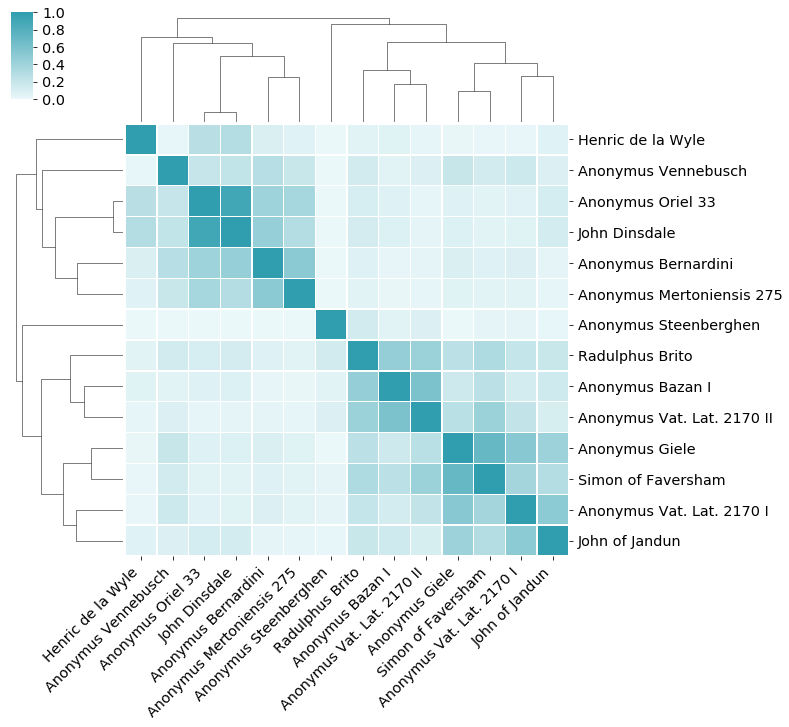

In [188]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [190]:
plot.savefig('../thesis/data/figures/science-rationes-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-rationes-proportional-clustermap', plot,
    caption='Proportional clustermap of rationes doctrines.',
    label='fig:sci:rationes:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-rationes-proportional-clustermap.pdf}
\caption{Proportional clustermap of rationes doctrines.}
\label{fig:sci:rationes:prop-clustermap}
\end{figure}


## Binary doctrines

In [192]:
# All doctrines except the base statement of the science
def all_rationes_doctrines():
    q = ("MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS]-(d)"
         "RETURN distinct(d.name) ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_rationes_doctrines()

# Test output
len(all_docs)

18

In [194]:
def all_rationes_doctrines_of(name):
    q = ("MATCH (r:Doctrine) WHERE r.name='There can be a science of the soul'"
         "MATCH (r)<-[:ATTACKS]-(d:Doctrine)"
         "MATCH (a:Author)--(t:Text)--(q:Question)--(d)"
         "WHERE a.name = '{name}'"
         "RETURN distinct(d.name)".format(name=name))
    return [t[0] for t in run_query(q).values()]

# Example test
all_rationes_doctrines_of("John of Jandun")

['No science about corruptible things, so no science about the soul',
 'Intellect denudated of object before knowledge, so no science of the soul',
 'No identity of mover and moved, so no science of the soul',
 'No sense perception of the soul, so there cannot be a science about it',
 'Soul not intelligible to us',
 'No science about the non-existent, so no science about the soul',
 'Soul is a particular, so there can be no science about it',
 'No identity between knower and known, so no science of the soul']

In [195]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = all_rationes_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

,Radulphus Brito,John of Jandun,Henric de la Wyle,Anonymus Oriel 33,John Dinsdale,Anonymus Mertoniensis 275,Anonymus Bernardini,Anonymus Vat. Lat. 2170 I,Anonymus Steenberghen,Anonymus Vennebusch,Simon of Faversham,Anonymus Bazan I,Anonymus Vat. Lat. 2170 II,Anonymus Giele
"Act and potency problem, so no science of the soul",x,,,,,,,,,,,,,
"Intellect denudated of object before knowledge, so no science of the soul",,x,,,,,,,,,,,,
"Knowledge is continuous and temporal, so no science of the soul",,,x,x,x,x,x,,,,,,,
"No identity between knower and known, so no science of the soul",,x,,,,,,x,,,,,,
"No identity of mover and moved, so no science of the soul",,x,x,x,x,,,,,,,,,
"No intellectual self-knowledge, so no science of the soul",,,,,,x,,,,,,,,
"No phantasm from the soul, so no science about it",,,x,,,x,x,,,,,,,
"No science about corruptible things, so no science about the soul",,x,,,,,,x,x,,,,,
"No science about the non-existent, so no science about the soul",,x,,,,,,,,,,,,
"No sense perception of the soul, so there cannot be a science about it",x,x,,x,x,x,x,x,,x,x,x,x,x


And now a bit of quantitative info.

In [196]:
df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums
#print(sums.to_latex())

John of Jandun                8
Anonymus Mertoniensis 275     6
John Dinsdale                 5
Anonymus Oriel 33             5
Henric de la Wyle             5
Simon of Faversham            4
Anonymus Bernardini           4
Radulphus Brito               4
Anonymus Bazan I              3
Anonymus Vat. Lat. 2170 I     3
Anonymus Giele                2
Anonymus Vat. Lat. 2170 II    2
Anonymus Vennebusch           2
Anonymus Steenberghen         2
dtype: int64

In [197]:
df.sum().mean()

3.9285714285714284

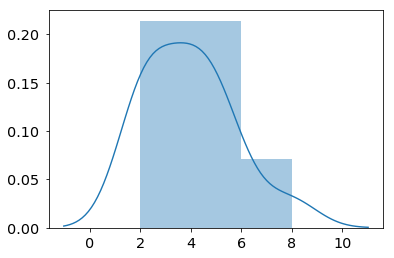

In [198]:
sns.distplot(df.sum())

In [199]:
df.sum(axis=1).sort_values(ascending=False)

No sense perception of the soul, so there cannot be a science about it           12
Soul not intelligible to us                                                       6
Knowledge is continuous and temporal, so no science of the soul                   5
Science about subject with parts and properties, so no science about the soul     5
Things most manifest in nature are opaque, so no science of the soul              4
No identity of mover and moved, so no science of the soul                         4
Soul is a particular, so there can be no science about it                         3
No science about corruptible things, so no science about the soul                 3
No phantasm from the soul, so no science about it                                 3
No identity between knower and known, so no science of the soul                   2
No intellectual self-knowledge, so no science of the soul                         1
Intellect denudated of object before knowledge, so no science of the soul   

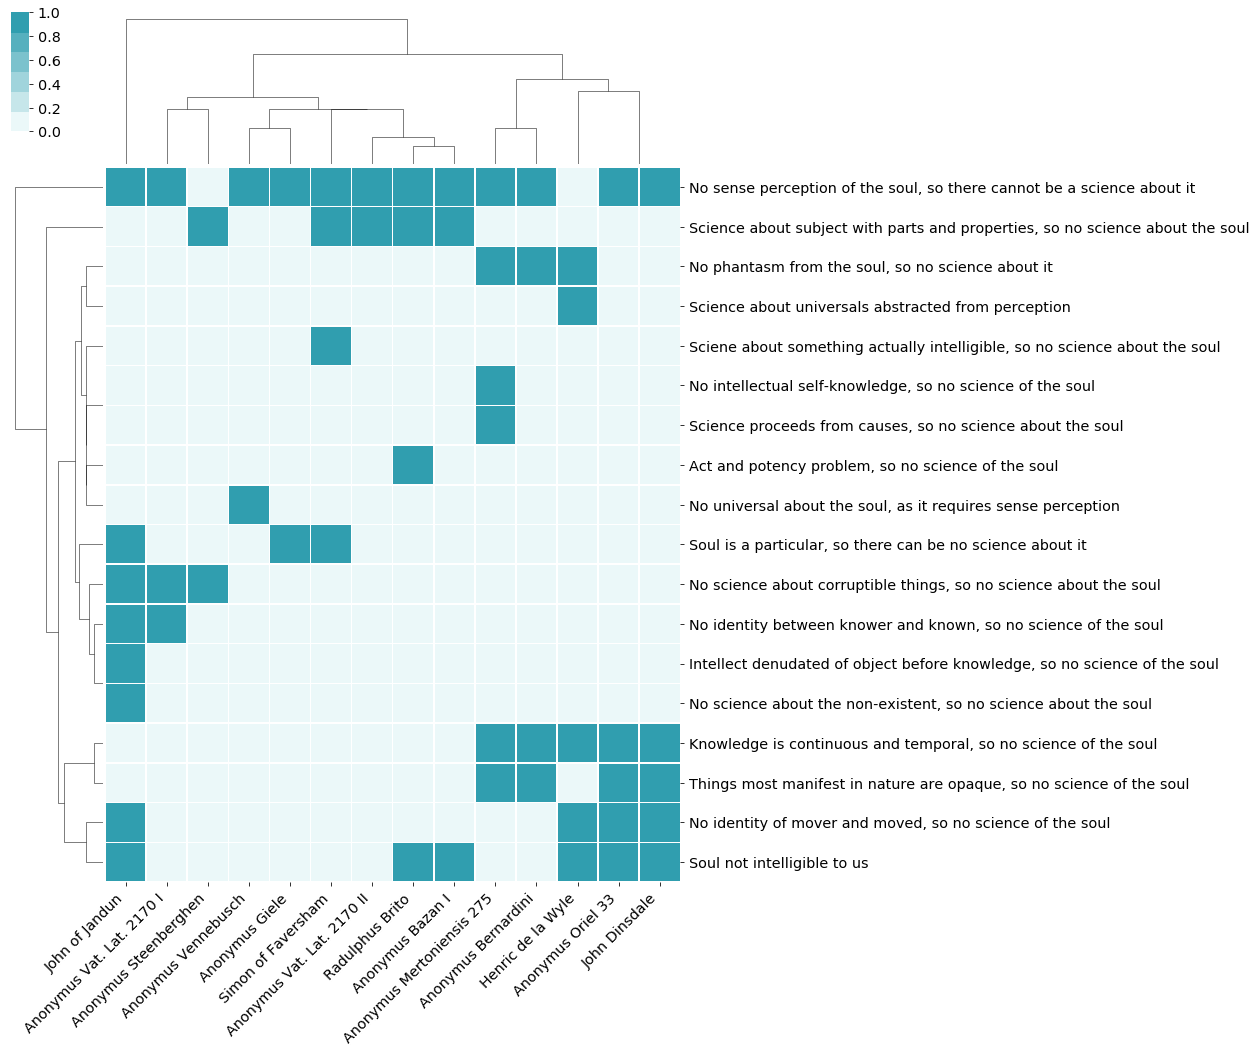

In [203]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, metric='hamming', 
                      row_cluster=True, figsize=(12,16))

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')
    
plot.savefig('../thesis/data/figures/science-determinations-binary-cluster.png')

In [661]:
plot.savefig('../figures/science-rationes-binary-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-rationes-binary-clustermap', plot,
    caption='Binary clustermap of rationes doctrines.',
    label='fig:sci:rationes:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-rationes-binary-clustermap.pdf}
\caption{Binary clustermap of rationes doctrines.}
\label{fig:sci:rationes:binary-clustermap}
\end{figure}
